In [1]:
%matplotlib inline

import logging
logging.getLogger('tensorflow').disabled = True

import sys
sys.path.append("../../TransportNets")

import numpy as np
import matplotlib.pyplot as plt; plt.style.use('seaborn-bright')

import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.image as mpimg
import time
import pandas as pd
from pandas.plotting import scatter_matrix
import h5py

tfd = tfp.distributions
tfb = tfp.bijectors

from Models.NVP import NVP
from Probability.MCMC import RTO_MH

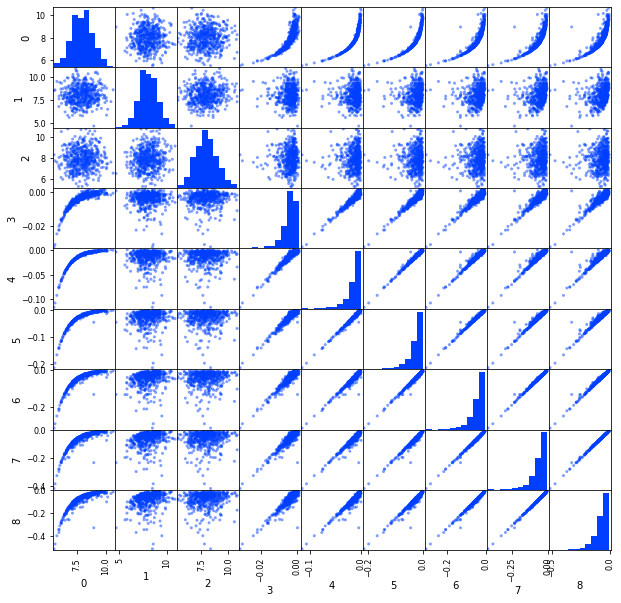

In [2]:
# visualizing joint distribution p(m,y) where 
# dim(m) = 3, dim(y) = 6
file = h5py.File('BeamSamples.h5','r')
joint_samps = np.array(file['Samples/'])
scatter_matrix(pd.DataFrame(joint_samps[::100,:]), figsize=(10,10), alpha=.5)
plt.show()

In [3]:
# Make target density and latent density
target = tf.constant(joint_samps[::5,:],dtype=tf.float32)

num_samples = target.shape[0] # Number of Target Samples
dim = target.shape[1] # Dimensionality of Data

latent = tf.random.normal([num_samples,dim],mean=0.0,stddev=1.0)

In [4]:
# Create model object
nvp = NVP(num_masked=4, output_dim=dim, num_layers=10,neuron_list=[500,500])

# Create optimizer and compile nvp with it
opt = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-06)
nvp.compile(opt)

# Perform a forward pass to initialize variables
_ = nvp(latent)

In [5]:
# Define training options
n_epochs = 50
batch_size = 50

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target)
dataset = dataset.shuffle(buffer_size=5000).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
history = nvp.fit(dataset, epochs=n_epochs)  # Pass callback to training

# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/50
200/200 [==============================] - 7s 34ms/step - Negative Log Likelihood: -15.5801
Epoch 2/50
200/200 [==============================] - 7s 34ms/step - Negative Log Likelihood: -21.4216
Epoch 3/50
200/200 [==============================] - 7s 37ms/step - Negative Log Likelihood: -22.9115
Epoch 4/50
200/200 [==============================] - 7s 34ms/step - Negative Log Likelihood: -23.8294
Epoch 5/50
200/200 [==============================] - 7s 35ms/step - Negative Log Likelihood: -24.3884
Epoch 6/50
200/200 [==============================] - 7s 34ms/step - Negative Log Likelihood: -24.8018
Epoch 7/50
200/200 [==============================] - 7s 35ms/step - Negative Log Likelihood: -25.0472
Epoch 8/50
200/200 [==============================] - 7s 34ms/step - Negative Log Likelihood: -25.2657
Epoch 9/50
200/200 [==============================] - 7s 35ms/step - Negative Log Likelihood: -25.4346
Epoch 10/50
200/200 [==============================] - 7s 34ms/step - Neg

<Figure size 1080x1080 with 0 Axes>

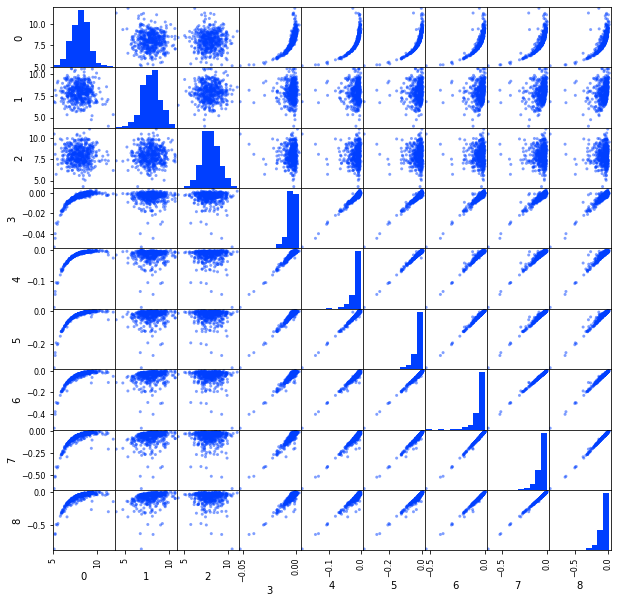

In [6]:
fig = plt.figure(figsize=(15,15))
R = tf.random.normal([500,dim],mean=0.0,stddev=1.0)
x_forward = nvp(R)
scatter_matrix(pd.DataFrame(x_forward.numpy()), figsize=(10,10))
plt.savefig('Euler-Beam-joint-density-nvp.png')
plt.show()

In [7]:
noiseStd = .01
S = noiseStd*tf.eye(6)

In [8]:
rto = RTO_MH(nvp, 9, 6)

In [9]:
n_acc, X_cond = rto.run(1000, S)

Acceptance Rate:  0.745
Run time:  836.9197568893433


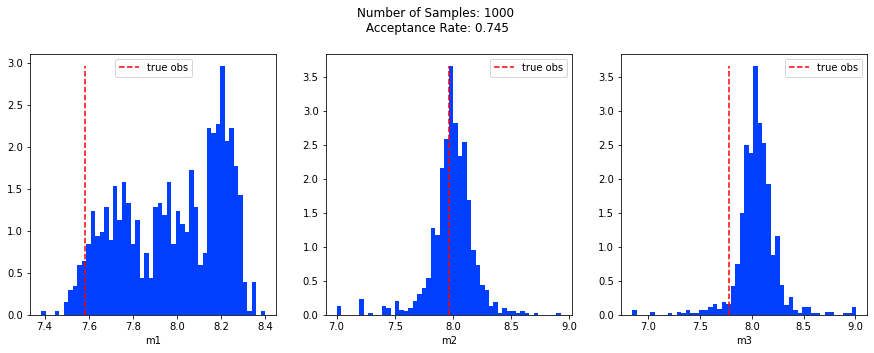

In [11]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
m1,m2,m3 = tuple(rto.joint_sample[0,:(rto.n-rto.m)])
counts,bins = np.histogram(X_cond[:,0],50,density=True)
axs[0].hist(bins[:-1],bins,weights=counts)
x = np.linspace(m1,m1,100)
y = np.linspace(0,max(counts),100)
axs[0].plot(x,y,'r--',label='true obs')
axs[0].set_xlabel('m1')
axs[0].legend()
counts,bins = np.histogram(X_cond[:,1],50,density=True)
axs[1].hist(bins[:-1],bins,weights=counts)
x = np.linspace(m2,m2,100)
y = np.linspace(0,max(counts),100)
axs[1].plot(x,y,'r--',label='true obs')
axs[1].set_xlabel('m2')
axs[1].legend()
counts,bins = np.histogram(X_cond[:,2],50,density=True)
plt.hist(bins[:-1],bins,weights=counts)
x = np.linspace(m3,m3,100)
y = np.linspace(0,max(counts),100)
axs[2].plot(x,y,'r--',label='true obs')
axs[2].set_xlabel('m3')
axs[2].legend()
plt.suptitle('Number of Samples: %d\n Acceptance Rate: %0.3f'%(rto.n_samples,rto.n_acc/rto.n_samples))
plt.subplots_adjust(top=0.85)
plt.savefig('Euler_Beam_RTO_MH_samples.png')